In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.regularizers import l2


In [2]:
DATASET_PATH = r"./Dataset"
# testdir = os.path.join(DATASET_PATH, 'Testing')
# print(testdir)
# print(os.listdir(testdir))

In [3]:
IMG_SIZE = 128  # Resize images to 128x128
BATCH_SIZE = 16
EPOCHS = 10
CLASSES = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
TRAIN_PATH = os.path.join(DATASET_PATH, "Training")
TEST_PATH = os.path.join(DATASET_PATH, "Testing")


In [4]:
def load_data(dataset_path):
    images = []
    labels = []
    
    for label_idx, class_name in enumerate(CLASSES):
        class_path = os.path.join(dataset_path, class_name)
        for file in os.listdir(class_path):
            if file.endswith('.jpg') or file.endswith('.png'):
                image_path = os.path.join(class_path, file)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize
                images.append(image)
                labels.append(label_idx)
    
    images = np.array(images) / 255.0  # Normalize images
    labels = np.array(labels)
    images = np.expand_dims(images, axis=-1)  # Add channel dimension
    return images, labels

print("Loading training data...")
X_train, y_train = load_data(TRAIN_PATH)
print("Loading testing data...")
X_test, y_test = load_data(TEST_PATH)

# One-hot encode labels for classification
y_train_onehot = to_categorical(y_train, num_classes=len(CLASSES))
y_test_onehot = to_categorical(y_test, num_classes=len(CLASSES))

print(f"Training data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Labels: {y_test.shape}")


Loading training data...
Loading testing data...
Training data shape: (2870, 128, 128, 1), Labels: (2870,)
Testing data shape: (394, 128, 128, 1), Labels: (394,)


Displaying sample training images:


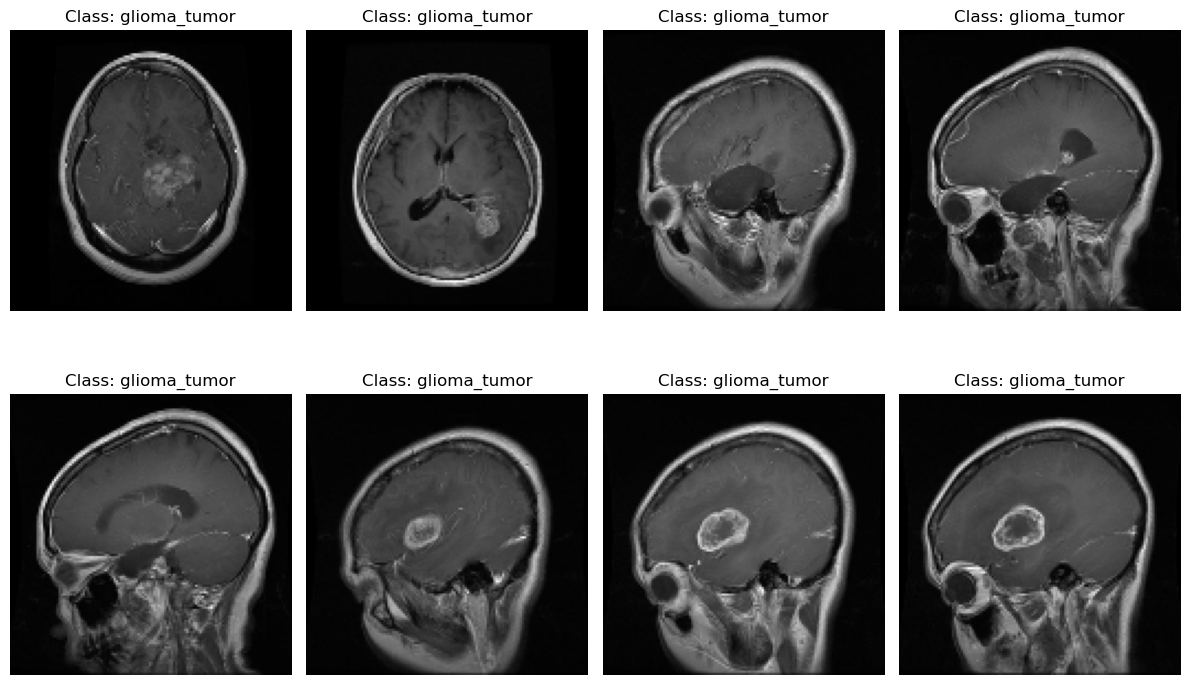

In [5]:
def display_images(images, labels, num_images=8):
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Class: {CLASSES[labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Displaying sample training images:")
display_images(X_train, y_train)


In [6]:
def build_classifier(input_size=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = Input(input_size)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.6)(x)
    outputs = Dense(len(CLASSES), activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

classifier_model = build_classifier()
classifier_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0     

In [7]:
classifier_model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

print("Training classification model...")
history = classifier_model.fit(X_train, y_train_onehot,
                               validation_data=(X_test, y_test_onehot),
                               epochs=EPOCHS, batch_size=BATCH_SIZE)



Training classification model...
Epoch 1/10
180/180 [==============================] - 33s 171ms/step - loss: 0.9499 - accuracy: 0.5927 - val_loss: 1.8156 - val_accuracy: 0.4822
Epoch 2/10
180/180 [==============================] - 30s 167ms/step - loss: 0.6025 - accuracy: 0.7575 - val_loss: 1.7799 - val_accuracy: 0.5381
Epoch 3/10
180/180 [==============================] - 29s 162ms/step - loss: 0.4495 - accuracy: 0.8178 - val_loss: 1.9994 - val_accuracy: 0.5761
Epoch 4/10
180/180 [==============================] - 31s 175ms/step - loss: 0.3434 - accuracy: 0.8700 - val_loss: 2.1542 - val_accuracy: 0.6624
Epoch 5/10
180/180 [==============================] - 29s 161ms/step - loss: 0.2445 - accuracy: 0.9070 - val_loss: 2.2600 - val_accuracy: 0.6853
Epoch 6/10
180/180 [==============================] - 29s 161ms/step - loss: 0.2166 - accuracy: 0.9188 - val_loss: 2.6831 - val_accuracy: 0.6447
Epoch 7/10
180/180 [==============================] - 28s 158ms/step - loss: 0.1696 - accuracy: 0

In [8]:
# Evaluate model
test_loss, test_acc = classifier_model.evaluate(X_test, y_test_onehot)
print(f"Test Accuracy: {test_acc:.4f}")


13/13 [==============================] - 1s 94ms/step - loss: 3.4291 - accuracy: 0.7563
Test Accuracy: 0.7563


In [ ]:
classifier_model.save(r'./Trained_brain_tumer_classifier.h5')

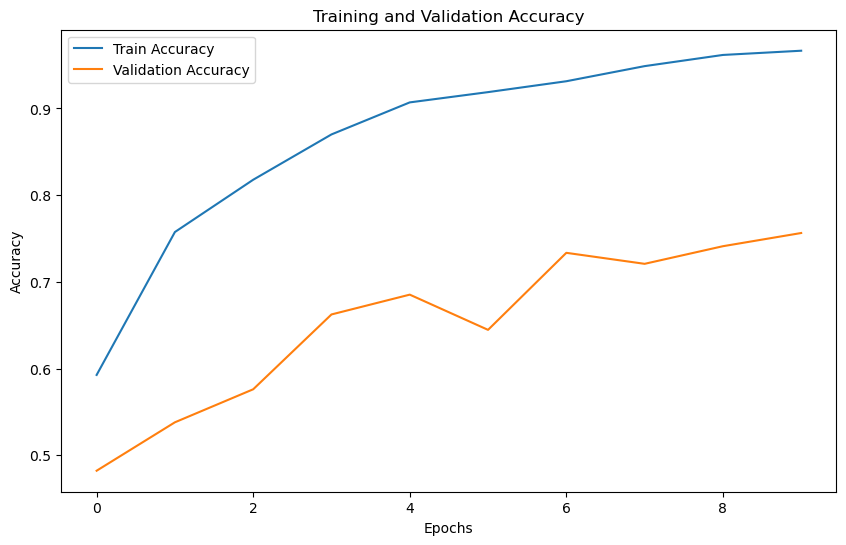

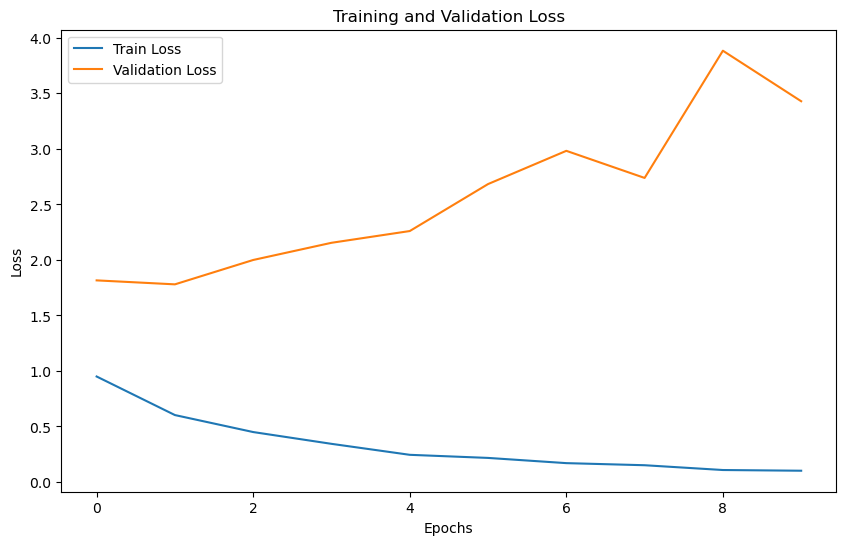

In [10]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


1/1 [==============================] - 0s 276ms/step


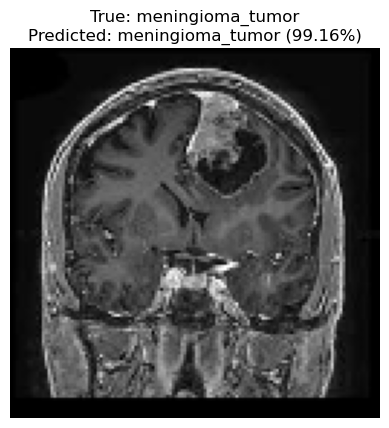

True Label: meningioma_tumor
Prediction: meningioma_tumor with confidence 99.16%


In [11]:
def predict_from_dataset(index, images, labels, model, class_names):
    """
    Predict the class of an image from the dataset.

    Args:
        index (int): Index of the image in the dataset.
        images (numpy.ndarray): Array of preprocessed images.
        labels (numpy.ndarray): Array of true labels.
        model (tf.keras.Model): Trained classification model.
        class_names (list): List of class names.

    Returns:
        None: Displays the image, true label, and predicted class.
    """
    # Select the image and true label
    image = images[index]
    true_label = class_names[labels[index]]

    # Add batch dimension for prediction
    image_input = np.expand_dims(image, axis=0)

    # Predict the class
    predictions = model.predict(image_input)
    predicted_class_idx = np.argmax(predictions)
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx] * 100

    # Display the image, true label, and prediction
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"True: {true_label}\nPredicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    print(f"True Label: {true_label}")
    print(f"Prediction: {predicted_class} with confidence {confidence:.2f}%")

# Select an image by index
image_index = 180  # Change this index to test other images
predict_from_dataset(image_index, X_test, y_test, classifier_model, CLASSES)


13/13 [==============================] - 1s 96ms/step


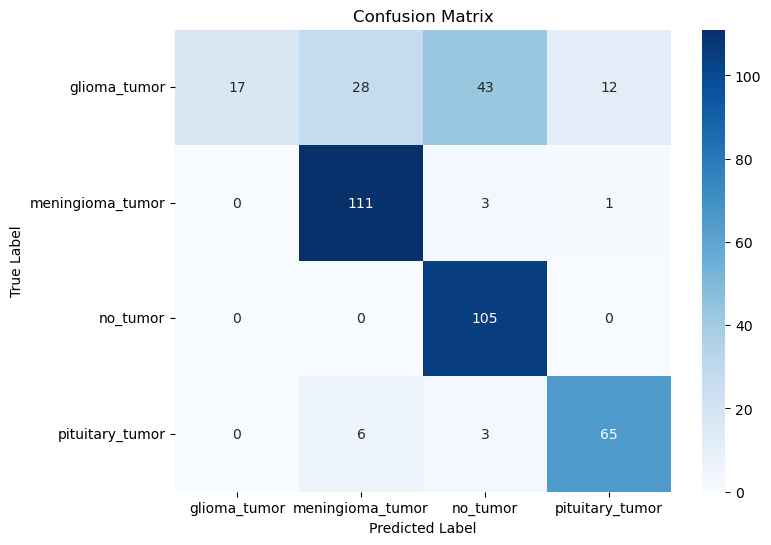

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on test set
y_pred = classifier_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def error_categorization(images, labels, model, class_names, display_errors=True):
    """
    Categorizes and summarizes errors for all testing images.
    
    Args:
        images (numpy.ndarray): Array of test images.
        labels (numpy.ndarray): True labels for test images.
        model (tf.keras.Model): Trained classification model.
        class_names (list): List of class names.
        display_errors (bool): If True, displays sample misclassified images.
        
    Returns:
        error_summary (dict): A dictionary summarizing error categories.
    """
    # Initialize an error dictionary to store misclassifications
    error_summary = defaultdict(list)

    # Loop through all test images
    for i in range(len(images)):
        image = images[i]  # Single image
        true_label_idx = labels[i]
        true_label = class_names[true_label_idx]

        # Add batch dimension for prediction
        image_input = np.expand_dims(image, axis=0)

        # Predict the class
        predictions = model.predict(image_input, verbose=0)
        predicted_class_idx = np.argmax(predictions)
        predicted_class = class_names[predicted_class_idx]

        # Check for misclassification
        if predicted_class_idx != true_label_idx:
            # Add to error summary: True Class -> Predicted Class
            error_key = f"{true_label} → {predicted_class}"
            error_summary[error_key].append(i)  # Store image index

    # Display error summary
    print("Error Categorization Summary:")
    for error_type, indices in error_summary.items():
        print(f"{error_type}: {len(indices)} errors")

    # Optionally display sample misclassified images
    if display_errors:
        print("\nDisplaying sample misclassified images:")
        plt.figure(figsize=(12, 8))
        sample_count = 0
        for error_type, indices in error_summary.items():
            for idx in indices[:2]:  # Display at most 2 samples per error category
                sample_count += 1
                plt.subplot(3, 4, sample_count)
                plt.imshow(images[idx].squeeze(), cmap='gray')
                plt.title(f"True: {error_type.split(' → ')[0]}\nPred: {error_type.split(' → ')[1]}")
                plt.axis('off')
            if sample_count >= 12:  # Display at most 12 images
                break
        plt.tight_layout()
        plt.show()

    return error_summary

# Example usage
error_summary = error_categorization(X_test, y_test, classifier_model, CLASSES, display_errors=False)


Error Categorization Summary:
glioma_tumor → pituitary_tumor: 12 errors
glioma_tumor → meningioma_tumor: 28 errors
glioma_tumor → no_tumor: 43 errors
meningioma_tumor → no_tumor: 3 errors
meningioma_tumor → pituitary_tumor: 1 errors
pituitary_tumor → no_tumor: 3 errors
pituitary_tumor → meningioma_tumor: 6 errors


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predictions on test data
y_pred = classifier_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
report = classification_report(y_test, y_pred_classes, target_names=CLASSES)
print("Classification Report:")
print(report)

# Accuracy Score
test_accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

13/13 [==============================] - 2s 109ms/step
Confusion Matrix:
[[ 17  28  43  12]
 [  0 111   3   1]
 [  0   0 105   0]
 [  0   6   3  65]]
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.17      0.29       100
meningioma_tumor       0.77      0.97      0.85       115
        no_tumor       0.68      1.00      0.81       105
 pituitary_tumor       0.83      0.88      0.86        74

        accuracy                           0.76       394
       macro avg       0.82      0.75      0.70       394
    weighted avg       0.82      0.76      0.70       394

Test Accuracy: 0.7563
